# Quick Start

This quick start will show how to do the following:

- `Install` everything needed to use pyGAM.
- `fit a regression model` with custom terms
- search for the `best smoothing parameters`
- plot `partial dependence` functions


## Install pyGAM
#### Pip

    pip install pygam


#### Conda
pyGAM is on conda-forge, however this is typically less up-to-date:

    conda install -c conda-forge pygam
    

#### Bleeding edge
You can install the bleeding edge from github using `poetry`.
First clone the repo, ``cd`` into the main directory and do:

    pip install -e .

#### Get `pandas` and `matplotlib`

    pip install pandas matplotlib



## Fit a Model

Let's get to it. First we need some data:

In [1]:
from pygam.datasets import wage

X, y = wage()

/home/dswah/miniconda3/envs/pygam36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


Now let's import a GAM that's made for regression problems.

Let's fit a spline term to the first 2 features, and a factor term to the 3rd feature.

In [2]:
from pygam import LinearGAM, f, s

gam = LinearGAM(s(0) + s(1) + f(2)).fit(X, y)

Let's take a look at the model fit:

In [3]:
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     25.1911
Link Function:                     IdentityLink Log Likelihood:                                -24118.6847
Number of Samples:                         3000 AIC:                                            48289.7516
                                                AICc:                                           48290.2307
                                                GCV:                                             1255.6902
                                                Scale:                                           1236.7251
                                                Pseudo R-Squared:                                   0.2955
Feature Function                  Lam

Even though we have 3 terms with a total of `(20 + 20 + 5) = 45` free variables, the default smoothing penalty (`lam=0.6`) reduces the effective degrees of freedom to just ~25.

By default, the spline terms, `s(...)`, use 20 basis functions. This is a good starting point. The rule of thumb is to use a fairly large amount of flexibility, and then let the smoothing penalty regularize the model.

However, we can always use our expert knowledge to add flexibility where it is needed, or remove basis functions, and make fitting easier:

In [22]:
gam = LinearGAM(s(0, n_splines=5) + s(1) + f(2)).fit(X, y)

## Automatically tune the model

By default, spline terms, `s()` have a penalty on their 2nd derivative, which encourages the functions to be smoother, while factor terms, `f()` and linear terms `l()`, have a l2, ie ridge penalty, which encourages them to take on smaller values.

`lam`, short for $\lambda$, controls the strength of the regularization penalty on each term. Terms can have multiple penalties, and therefore multiple `lam`.

In [14]:
print(gam.lam)

[[0.6], [0.6], [0.6]]


Our model has 3 `lam` parameters, currently just one per term.

Let's perform a grid-search over multiple `lam` values to see if we can improve our model.  
We will seek the model with the lowest generalized cross-validation (GCV) score.

Our search space is 3-dimensional, so we have to be conservative with the number of points we consider per dimension.

Let's try 5 values for each smoothing parameter, resulting in a total of `5*5*5 = 125` points in our grid.

In [15]:
import numpy as np

lam = np.logspace(-3, 5, 5)
lams = [lam] * 3

gam.gridsearch(X, y, lam=lams)
gam.summary()

100% (125 of 125) |######################| Elapsed Time: 0:00:07 Time:  0:00:07


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      9.2948
Link Function:                     IdentityLink Log Likelihood:                                -24119.7277
Number of Samples:                         3000 AIC:                                            48260.0451
                                                AICc:                                           48260.1229
                                                GCV:                                              1244.089
                                                Scale:                                           1237.1528
                                                Pseudo R-Squared:                                   0.2915
Feature Function                  Lam

This is quite a bit better. Even though the in-sample $R^2$ value is lower, we can expect our model to generalize better because the GCV error is lower.

We could be more rigorous by using a train/test split, and checking our model's error on the test set. We were also quite lazy and only tried 125 values in our hyperopt. We might find a better model if we spent more time searching across more points.

For high-dimensional search-spaces, it is sometimes a good idea to try a **randomized search**.  
We can achieve this by using numpy's `random` module:

In [16]:
lams = np.random.rand(100, 3)  # random points on [0, 1], with shape (100, 3)
lams = lams * 6 - 3  # shift values to -3, 3
lams = 10**lams  # transforms values to 1e-3, 1e3

In [17]:
random_gam = LinearGAM(s(0) + s(1) + f(2)).gridsearch(X, y, lam=lams)
random_gam.summary()

100% (100 of 100) |######################| Elapsed Time: 0:00:07 Time:  0:00:07


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     15.6683
Link Function:                     IdentityLink Log Likelihood:                                -24115.6727
Number of Samples:                         3000 AIC:                                            48264.6819
                                                AICc:                                           48264.8794
                                                GCV:                                             1247.2011
                                                Scale:                                           1235.4817
                                                Pseudo R-Squared:                                   0.2939
Feature Function                  Lam

In this case, our deterministic search found a better model:

In [18]:
gam.statistics_["GCV"] < random_gam.statistics_["GCV"]

True

The `statistics_` attribute is populated after the model has been fitted.
There are lots of interesting model statistics to check out, although many are automatically reported in the model summary:

In [19]:
list(gam.statistics_.keys())

['n_samples',
 'm_features',
 'edof_per_coef',
 'edof',
 'scale',
 'cov',
 'se',
 'AIC',
 'AICc',
 'pseudo_r2',
 'GCV',
 'UBRE',
 'loglikelihood',
 'deviance',
 'p_values']

## Partial Dependence Functions

One of the most attractive properties of GAMs is that we can decompose and inspect the contribution of each feature to the overall prediction. 

This is done via **partial dependence** functions.

Let's plot the partial dependence for each term in our model, along with a 95% confidence interval for the estimated function.

In [20]:
import matplotlib.pyplot as plt

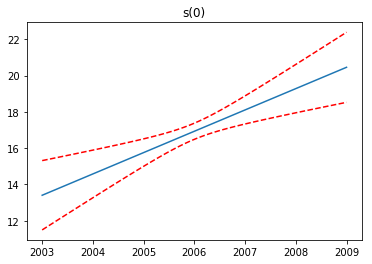

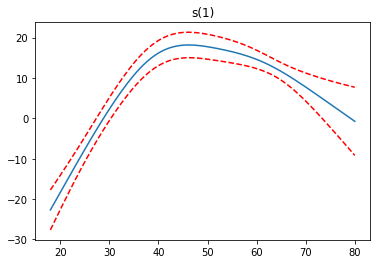

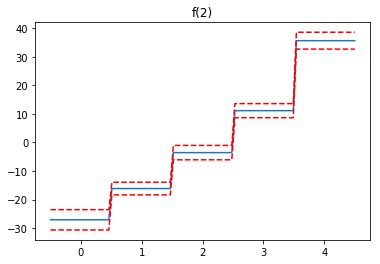

In [21]:
for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue

    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.95)

    plt.figure()
    plt.plot(XX[:, term.feature], pdep)
    plt.plot(XX[:, term.feature], confi, c="r", ls="--")
    plt.title(repr(term))
    plt.show()

Note: we skip the intercept term because it has nothing interesting to plot.